# Discretization
Here we will describe *Invert4Geom's* approach to discretization. Discretization refers to the process of transforming something of continuous-value (smoothly varying) into a discrete form. For example, a Digital Elevation Model (DEM) is a discretized representation of the elevation of a landscape. Each grid cell of the DEM has a discrete value.

In *Invert4Geom* we are interested in modeling the geometry (i.e. relief, topography) of some geologic layer. This maybe to the geometry of the Earth's surface (referred to as topography), the geometry of the Moho, or the geometry of the seafloor (bathymetry).

To do this, we must treat these geologic layers as density contrasts, separating materials of differing densities. For example, the Moho is the density contrast between the Earth's crust and mantle, or the Earth's surface, in terrestrial regions, is the density contrast between air and rock. 

To discretize these density contrasts, we use a single layer of adjacent, vertical, right-rectangular prisms, each assigned a density contrast value. This notebook walks you though how this discretization is achieved, using a synthetic dataset of topography. 

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os

import xarray as xr

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create some topography data
`Invert4Geom` uses the Python package `xarray` for handing gridded data. The format for this gridded data are `Datasets`, which have two coordinates (by convention we use the names `easting` and `northing`), and have variables, which for topography is the elevation (we use the name `upward`). `Datasets` can also include helpful metadata such as units and the data source. 

In this example, the topography represent the Moho.

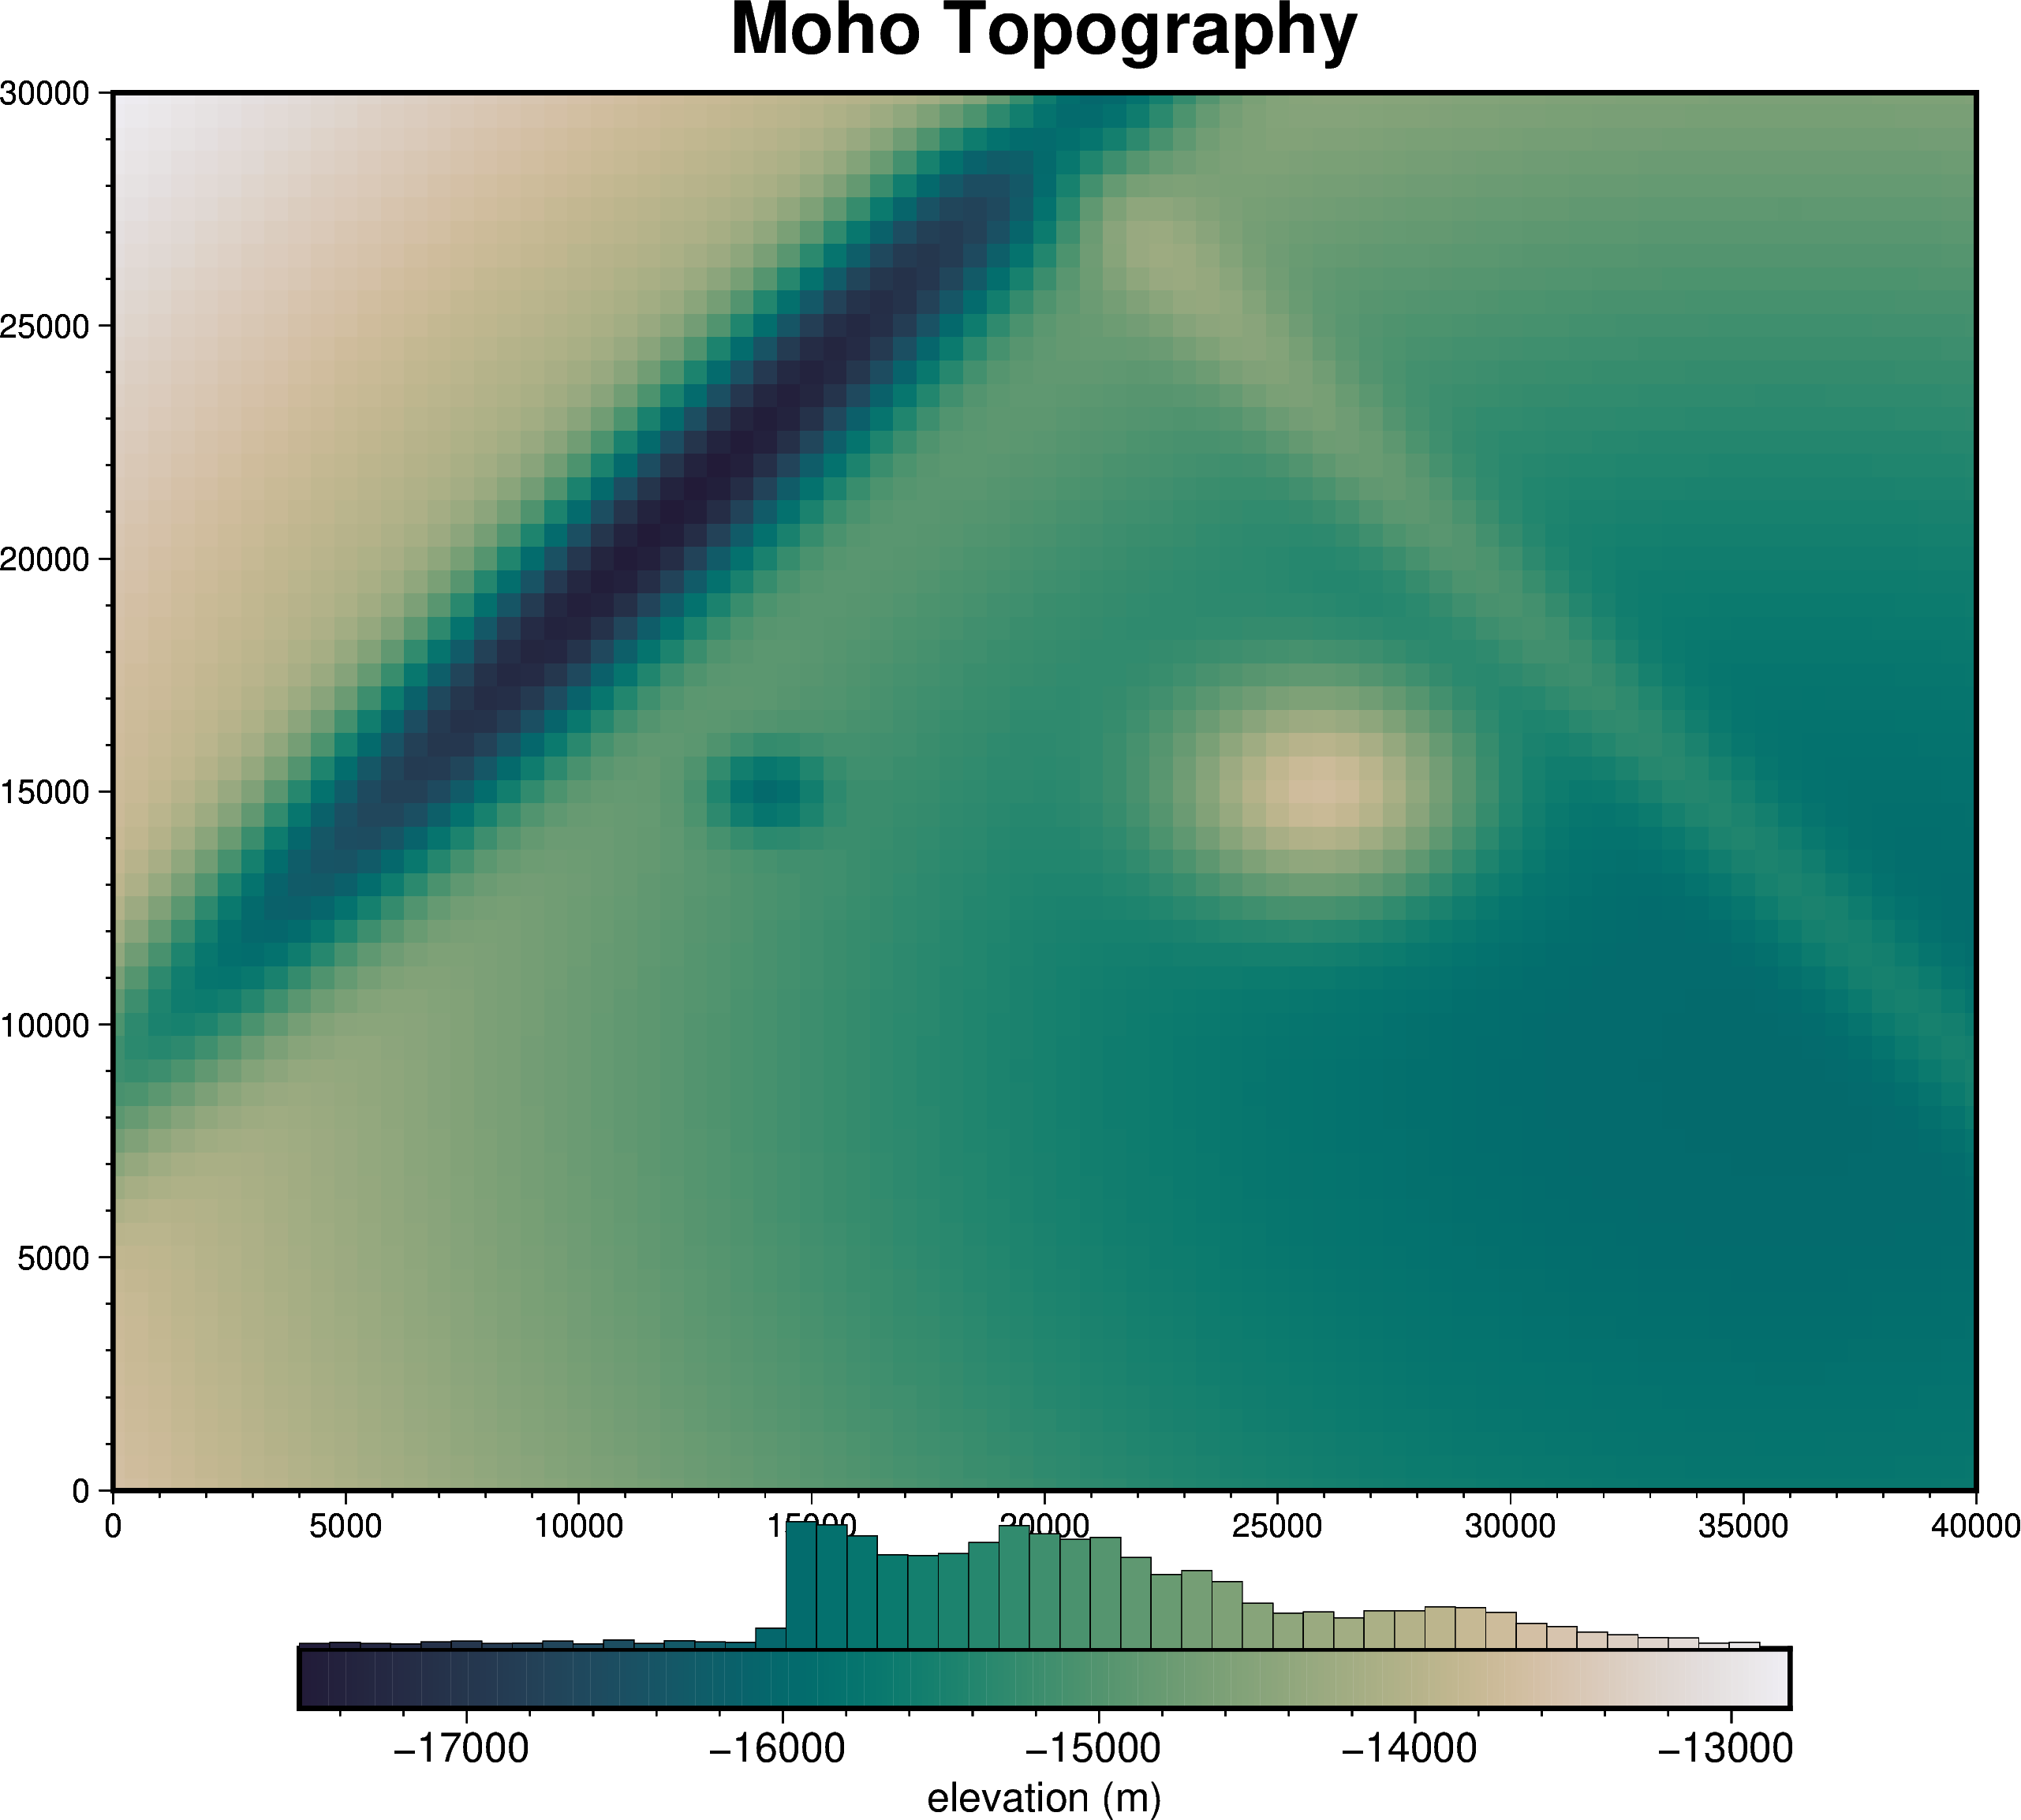

In [2]:
# create synthetic topography data
topography = invert4geom.synthetic_topography_simple(
    spacing=500,
    region=(0, 40000, 0, 30000),
    yoffset=-20000,
    scale=10,
    plot=True,
    title="Moho Topography",
)
topography = topography.to_dataset(name="upward")

We can see the structure of the dataset.

In [3]:
topography

<xarray.Dataset> Size: 41kB
Dimensions:   (easting: 81, northing: 61)
Coordinates:
  * easting   (easting) float64 648B 0.0 500.0 1e+03 ... 3.9e+04 3.95e+04 4e+04
  * northing  (northing) float64 488B 0.0 500.0 1e+03 ... 2.9e+04 2.95e+04 3e+04
Data variables:
    upward    (northing, easting) float64 40kB -1.363e+04 ... -1.458e+04

## Discretize the topography as prisms

We want to forward-model the gravity effect of this moho topography grid, which represent the density contrast between crust (above) and mantle (below). One way to do this is to create two layers of adjacent vertical prisms, one layer representing the crust and one layer representing the earth. 

For each prism layer, we need to choose a reference level (`zref`) which defines either the top or bottom of each prism, and a `density` value for each prism. 

For the upper prism layer (the crust), we can choose a `zref` of 0 m and a `density` of 2670 kg/m3.

In [4]:
crust_prisms = invert4geom.create_model(
    zref=0,
    density_contrast=2670,
    starting_topography=topography,
)
crust_prisms

<xarray.Dataset> Size: 357kB
Dimensions:                (northing: 61, easting: 81)
Coordinates:
  * easting                (easting) float64 648B 0.0 500.0 ... 3.95e+04 4e+04
  * northing               (northing) float64 488B 0.0 500.0 ... 2.95e+04 3e+04
    top                    (northing, easting) float64 40kB 0.0 0.0 ... 0.0 0.0
    bottom                 (northing, easting) float64 40kB -1.363e+04 ... -1...
Data variables:
    density                (northing, easting) int64 40kB -2670 -2670 ... -2670
    thickness              (northing, easting) float64 40kB 1.363e+04 ... 1.4...
    starting_topography    (northing, easting) float64 40kB -1.363e+04 ... -1...
    topography             (northing, easting) float64 40kB -1.363e+04 ... -1...
    mask                   (northing, easting) float64 40kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 40kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 40kB nan nan ... nan nan
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              0
    density_contrast:  2670
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           500.0
    dataset_type:      model

For the lower prism layer (the mantle), we can choose a `zref` of -50 km and a `density` of 3300 kg/m3.

In [5]:
mantle_prisms = invert4geom.create_model(
    zref=-40000,
    density_contrast=3300,
    starting_topography=topography,
)
mantle_prisms

<xarray.Dataset> Size: 357kB
Dimensions:                (northing: 61, easting: 81)
Coordinates:
  * easting                (easting) float64 648B 0.0 500.0 ... 3.95e+04 4e+04
  * northing               (northing) float64 488B 0.0 500.0 ... 2.95e+04 3e+04
    top                    (northing, easting) float64 40kB -1.363e+04 ... -1...
    bottom                 (northing, easting) float64 40kB -4e+04 ... -4e+04
Data variables:
    density                (northing, easting) int64 40kB 3300 3300 ... 3300
    thickness              (northing, easting) float64 40kB 2.637e+04 ... 2.5...
    starting_topography    (northing, easting) float64 40kB -1.363e+04 ... -1...
    topography             (northing, easting) float64 40kB -1.363e+04 ... -1...
    mask                   (northing, easting) float64 40kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 40kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 40kB nan nan ... nan nan
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              -40000
    density_contrast:  3300
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           500.0
    dataset_type:      model

We can view this prisms, and their assigned density contrasts.

ERROR:root:Bad table range: [2.22507e-308, -2670]
2025-09-19 19:30:20.819 (   8.753s) [    7F84DBBAC600]     vtkLookupTable.cxx:162    ERR| vtkLookupTable (0x5594e11483e0): Bad table range: [2.22507e-308, -2670]


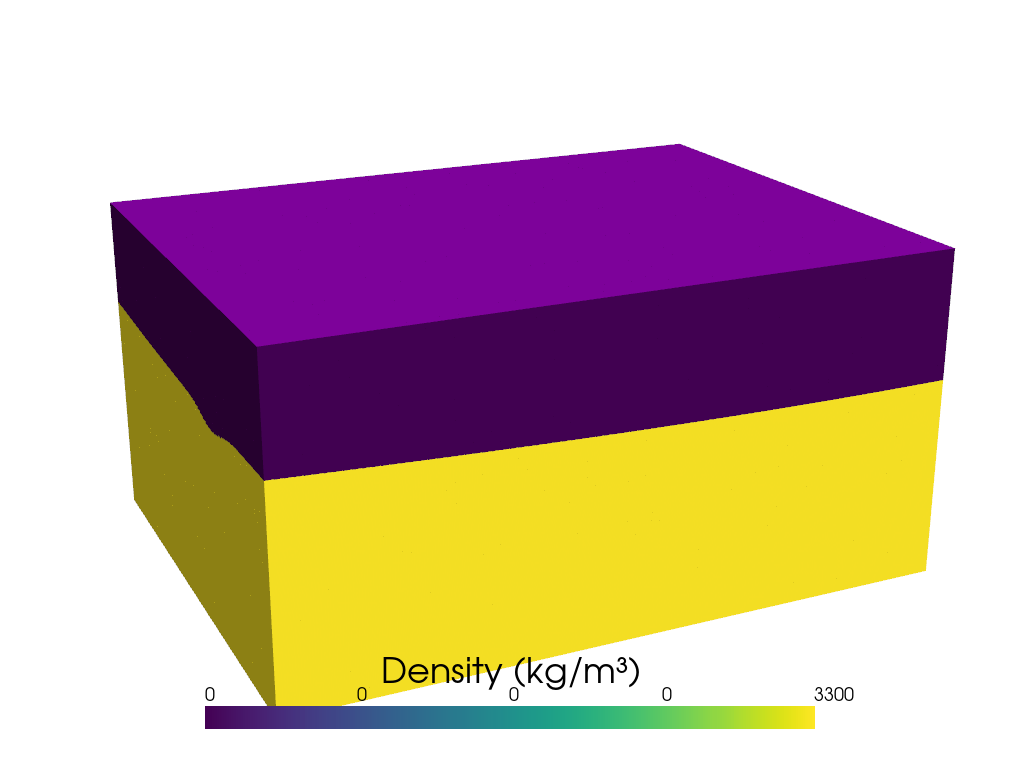

In [6]:
invert4geom.show_prism_layers(
    [crust_prisms, mantle_prisms],
    color_by="density",
    zscale=0.5,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Density (kg/m³)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)



as some vertical prisms, so we can calculate the gravity effect of each prism. A simple way to do this is to
This will convert each topographic grid cell into the a vertical prism. Each of these prisms is define by a top and a bottom. 

Each prism is created between the grid cell's elevation and the elevation of a chosen reference level, `zref`. The simple case is a `zref` which is lower than all points on the grid. This means each prism's bottom will be equal to `zref`, and each prism's topo is equal to the elevation of the corresponding topography grid cell. 

Additionally, we need to assign density, or density contrast values, to each prism. A simple case is constant density values which represent a certain medium (i.e. rock). Below we'll use the `create_model` function to create this simple prism layer. 

## Prisms as a density contrast

In `Invert4Geom`, we use a density contrast approach, where instead of useing two layers of prisms to represent a density contrast, we use a single layer of prisms. The prisms are assigned a `density contrast`, instead of an absolute `density`. Prisms which fall above the `zref` are assigned a positive density contrast, and those that fall below the `zref` are assigned a negative density contrast. 

We choose a `reference level` which is the mean of the moho depths.

In this example, the `density contrast` is between crust and mantle, so it has a value of 630 kg/m3 (3300 - 2670). 

In [7]:
model = invert4geom.create_model(
    zref=topography.upward.values.mean(),
    density_contrast=3300 - 2670,
    starting_topography=topography,
)
model

<xarray.Dataset> Size: 357kB
Dimensions:                (northing: 61, easting: 81)
Coordinates:
  * easting                (easting) float64 648B 0.0 500.0 ... 3.95e+04 4e+04
  * northing               (northing) float64 488B 0.0 500.0 ... 2.95e+04 3e+04
    top                    (northing, easting) float64 40kB -1.363e+04 ... -1...
    bottom                 (northing, easting) float64 40kB -1.509e+04 ... -1...
Data variables:
    density                (northing, easting) int64 40kB 630 630 ... 630 630
    thickness              (northing, easting) float64 40kB 1.462e+03 ... 510.0
    starting_topography    (northing, easting) float64 40kB -1.363e+04 ... -1...
    topography             (northing, easting) float64 40kB -1.363e+04 ... -1...
    mask                   (northing, easting) float64 40kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 40kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 40kB nan nan ... nan nan
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              -15090.63671954754
    density_contrast:  630
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           500.0
    dataset_type:      model

We can see that prisms above the reference level have a positive density value, and those below have a negative.

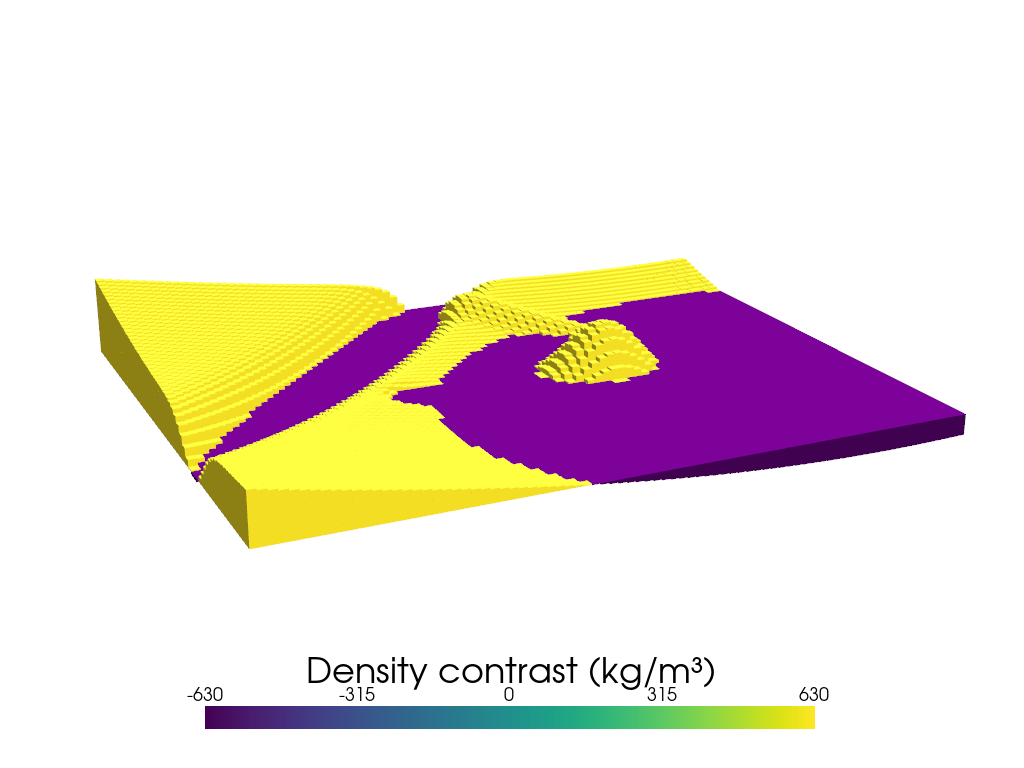

In [8]:
invert4geom.show_prism_layers(
    model,
    color_by="density",
    log_scale=False,
    zscale=2,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Density contrast (kg/m³)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

Below we instead color the prisms by their thickness. 

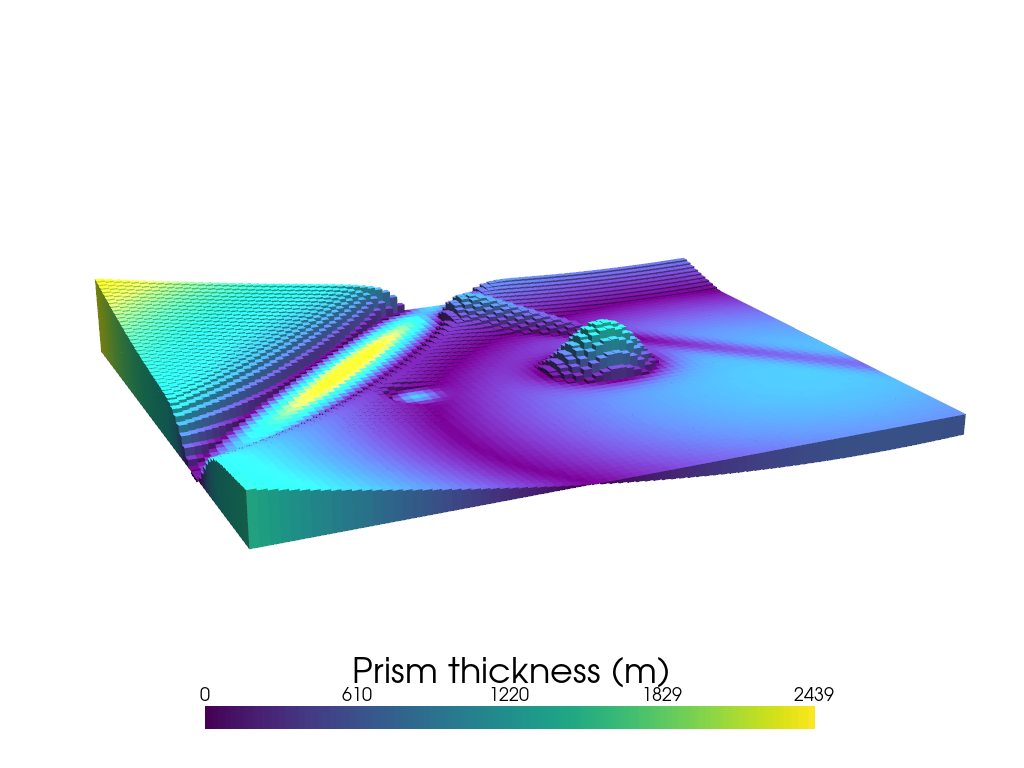

In [9]:
invert4geom.show_prism_layers(
    model,
    color_by="thickness",
    log_scale=False,
    zscale=2,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Prism thickness (m)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

### Masking the model

You can create a `mask` variable of the dataset which will determine which prisms can be altered during the inversion. 

Prisms with a `mask` value of 1 are free to change, while those with a value of 0 are held fixed.

Here, we assigned the shallow portions of the region to be constrained, but you can create the mask grid however you'd like.

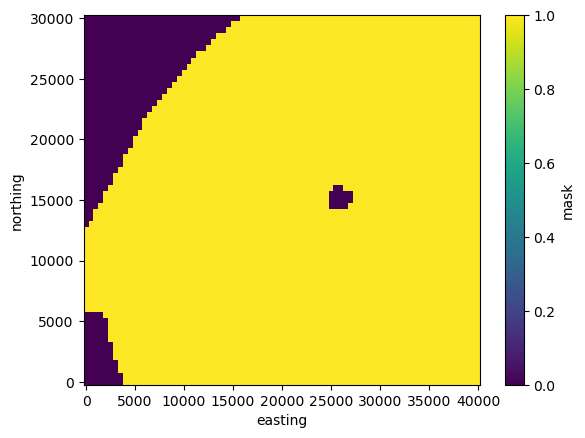

In [10]:
topography["mask"] = xr.where(topography.upward > -14000, 0, 1)
topography.mask.plot()

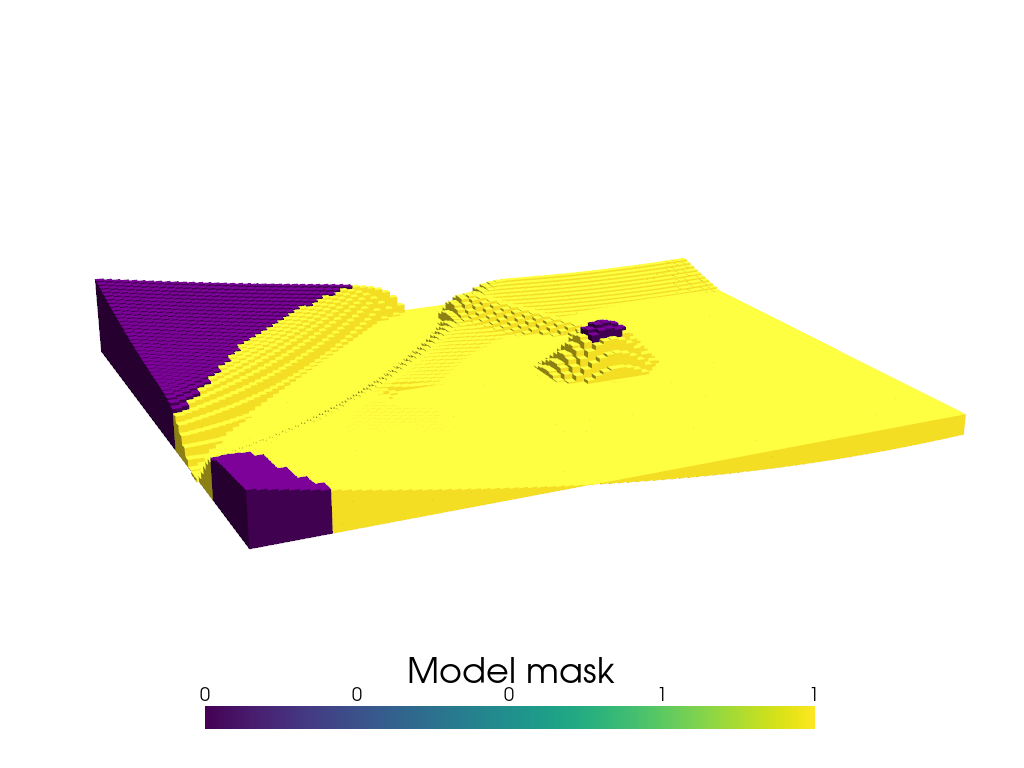

In [11]:
model = invert4geom.create_model(
    zref=topography.upward.values.mean(),
    density_contrast=3300 - 2670,
    starting_topography=topography,
)

invert4geom.show_prism_layers(
    model,
    color_by="mask",
    log_scale=False,
    zscale=2,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Model mask",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

See user guide [variable density contrast](variable_density_contrast.ipynb) for an example of how to incorparate spatially-variable density contrast values.